# 📓 Comprehensiveness Evaluations

In many ways, feedbacks can be thought of as LLM apps themselves. Given text,
they return some result. Thinking in this way, we can use TruLens to evaluate
and track our feedback quality. We can even do this for different models (e.g.
gpt-3.5 and gpt-4) or prompting schemes (such as chain-of-thought reasoning).

This notebook follows an evaluation of a set of test cases generated from human
annotated datasets. In particular, we generate test cases from
[MeetingBank](https://arxiv.org/abs/2305.17529) to evaluate our
comprehensiveness feedback function.

MeetingBank is one of the datasets dedicated to automated evaluations on
summarization tasks, which are closely related to the comprehensiveness
evaluation in RAG with the retrieved context (i.e. the source) and response
(i.e. the summary). It contains human annotation of numerical score (**1** to
**5**). 

For evaluating comprehensiveness feedback functions, we compute the annotated
"informativeness" scores, a measure of how well  the summaries capture all the
main points of the meeting segment. A good summary should contain all and only
the important information of the source., and normalized to **0** to **1** score
as our **expected_score** and to match the output of feedback functions.

In [1]:
import csv
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from trulens.core import Tru, Feedback, Select
from trulens.external import GroundTruthAgreement, OpenAI as fOpenAI

In [23]:
from test_cases import generate_meetingbank_comprehensiveness_benchmark

test_cases_gen = generate_meetingbank_comprehensiveness_benchmark(
    human_annotation_file_path="./datasets/meetingbank/human_scoring.json",
    meetingbank_file_path="YOUR_LOCAL_DOWNLOAD_PATH/MeetingBank/Metadata/MeetingBank.json",
)
length = sum(1 for _ in test_cases_gen)
test_cases_gen = generate_meetingbank_comprehensiveness_benchmark(
    human_annotation_file_path="./datasets/meetingbank/human_scoring.json",
    meetingbank_file_path="YOUR_LOCAL_DOWNLOAD_PATH/MeetingBank/Metadata/MeetingBank.json",
)

comprehensiveness_golden_set = []
for i in range(length):
    comprehensiveness_golden_set.append(next(test_cases_gen))

assert(len(comprehensiveness_golden_set) == length)

In [24]:
comprehensiveness_golden_set[:3]

[{'query': "speaker 10: Is public comment next, Madam Clerk.\nspeaker 2: And item ten is next door to. Well.\nspeaker 10: That was pulled as well.\nspeaker 2: Item ten Report from Parks, Recreation and Marine and Financial Management Recommendation to authorize the city manager to execute three new permits to operate Kiteboarding and stand up paddle boarding. Stand Up Paddle Boarding. Rental and instruction concessions on City of Long Beach Beaches District three.\nspeaker 1: Can you turn this over to Councilman Price?\nspeaker 8: Thank you. So this has been an item that we've received a lot of inquiry about over the last couple of weeks, actually, several months. But really, the the item has ramped up the discussion. So with that, I'd like to see if Parks Rec and Marine has a report to share with us that hopefully incorporate some of the\nspeaker 8: concerns that have been raised.\nspeaker 3: I'd like to hand this over to L.V. to Halloran, our bureau manager for our Marine Bureau in t

In [25]:
os.environ["OPENAI_API_KEY"] = "sk-..." # for groundtruth feedback function

In [26]:
tru = Tru()

provider_new_gpt_4o = fOpenAI(model_engine="gpt-4o")

provider_gpt_4 = fOpenAI(model_engine="gpt-4-turbo")

provider_gpt_35 = fOpenAI(model_engine="gpt-3.5-turbo")

In [27]:
# comprehensiveness of summary with transcript as reference
f_comprehensiveness_openai_gpt_35 = (
    Feedback(provider_gpt_35.comprehensiveness_with_cot_reasons)
    .on_input_output()
)

f_comprehensiveness_openai_gpt_4 = (
    Feedback(provider_gpt_4.comprehensiveness_with_cot_reasons)
    .on_input_output()
)

f_comprehensiveness_openai_gpt_4o = (
    Feedback(provider_new_gpt_4o.comprehensiveness_with_cot_reasons)
    .on_input_output()
)

✅ In comprehensiveness_with_cot_reasons, input source will be set to __record__.main_input or `Select.RecordInput` .
✅ In comprehensiveness_with_cot_reasons, input summary will be set to __record__.main_output or `Select.RecordOutput` .
✅ In comprehensiveness_with_cot_reasons, input source will be set to __record__.main_input or `Select.RecordInput` .
✅ In comprehensiveness_with_cot_reasons, input summary will be set to __record__.main_output or `Select.RecordOutput` .
✅ In comprehensiveness_with_cot_reasons, input source will be set to __record__.main_input or `Select.RecordInput` .
✅ In comprehensiveness_with_cot_reasons, input summary will be set to __record__.main_output or `Select.RecordOutput` .


In [28]:
# Create a Feedback object using the numeric_difference method of the
# ground_truth object.
ground_truth = GroundTruthAgreement(comprehensiveness_golden_set)

# Call the numeric_difference method with app and record and aggregate to get
# the mean absolute error.
f_mae = Feedback(
    ground_truth.mae,
    name="Mean Absolute Error"
).on(Select.Record.calls[0].args.args[0])\
 .on(Select.Record.calls[0].args.args[1])\
  .on_output()

✅ In Mean Absolute Error, input prompt will be set to __record__.calls[0].args.args[0] .
✅ In Mean Absolute Error, input response will be set to __record__.calls[0].args.args[1] .
✅ In Mean Absolute Error, input score will be set to __record__.main_output or `Select.RecordOutput` .


In [ ]:
from benchmark_frameworks.eval_as_recommendation \
    import compute_ndcg, compute_ece, recall_at_k, precision_at_k

scores_gpt_35 = []
scores_gpt_4 = []
scores_gpt_4o = []
true_scores = [] # human prefrences / scores

for i in range(190, len(comprehensiveness_golden_set)):
    source = comprehensiveness_golden_set[i]["query"]
    summary = comprehensiveness_golden_set[i]["response"]
    expected_score = comprehensiveness_golden_set[i]["expected_score"]

    feedback_score_gpt_35 = f_comprehensiveness_openai_gpt_35(source, summary)[0]
    feedback_score_gpt_4 = f_comprehensiveness_openai_gpt_4(source, summary)[0]
    feedback_score_gpt_4o = f_comprehensiveness_openai_gpt_4o(source, summary)[0]
  
    scores_gpt_35.append(feedback_score_gpt_35)
    scores_gpt_4.append(feedback_score_gpt_4)
    scores_gpt_4o.append(feedback_score_gpt_4o)
    true_scores.append(expected_score)

  
    
    df_results = pd.DataFrame({'scores (gpt-3.5-turbo)': scores_gpt_35, 
                                'scores (gpt-4)': scores_gpt_4,
                                'scores (gpt-4o)': scores_gpt_4o, 
                                'expected score': true_scores})

    # Save the DataFrame to a CSV file
    df_results.to_csv(
        './results/results_comprehensiveness_benchmark_new_3.csv',
        index=False
    )

In [52]:
mae_gpt_35 = sum(
    abs(score - true_score) \
    for score, true_score in zip(scores_gpt_35, true_scores)
) / len(scores_gpt_35)

mae_gpt_4 = sum(
     abs(score - true_score) \
    for score, true_score in zip(scores_gpt_4, true_scores)
) / len(scores_gpt_4)

mae_gpt_4o = sum(
     abs(score - true_score) \
    for score, true_score in zip(scores_gpt_4o, true_scores)
) / len(scores_gpt_4o)

In [53]:
print(f"MAE gpt-3.5-turbo: {mae_gpt_35}")
print(f"MAE gpt-4-turbo: {mae_gpt_4}")
print(f"MAE gpt-4o: {mae_gpt_4o}")

MAE gpt-3.5-turbo: 0.1705730397397064
MAE gpt-4-turbo: 0.16319927069927068
MAE gpt-4o: 0.18359294425951297


## Visualization to help investigation in LLM alignments with (mean) absolute errors

In [56]:
scores_gpt_4 = []
true_scores = []

# Open the CSV file and read its contents
with open("./results/results_comprehensiveness_benchmark.csv", 'r') as csvfile:
    # Create a CSV reader object
    csvreader = csv.reader(csvfile)
    
    # Skip the header row
    next(csvreader)
    
    # Iterate over each row in the CSV
    for row in csvreader:

        # Append the scores and true_scores to their respective lists
        scores_gpt_4.append(float(row[1]))
        true_scores.append(float(row[-1]))

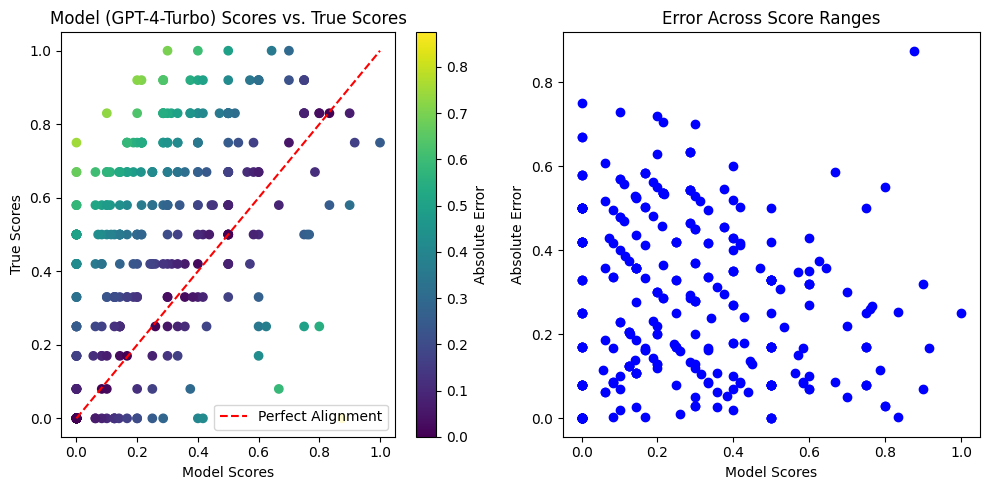

In [57]:
# Assuming scores and true_scores are flat lists of predicted probabilities and
# their corresponding ground truth relevances

# Calculate the absolute errors
errors = np.abs(np.array(scores_gpt_4) - np.array(true_scores))

# Scatter plot of scores vs true_scores
plt.figure(figsize=(10, 5))

# First subplot: scatter plot with color-coded errors
plt.subplot(1, 2, 1)
scatter = plt.scatter(scores_gpt_4, true_scores, c=errors, cmap='viridis')
plt.colorbar(scatter, label='Absolute Error')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Alignment')  # Line of perfect alignment
plt.xlabel('Model Scores')
plt.ylabel('True Scores')
plt.title('Model (GPT-4-Turbo) Scores vs. True Scores')
plt.legend()

# Second subplot: Error across score ranges
plt.subplot(1, 2, 2)
plt.scatter(scores_gpt_4, errors, color='blue')
plt.xlabel('Model Scores')
plt.ylabel('Absolute Error')
plt.title('Error Across Score Ranges')

plt.tight_layout()
plt.show()